In [1]:
from models.det_hist_glm import Det_Hist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 2000
epoch_no = 3000
layer_no = 3

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Det_Hist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

59


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, Z_pred, out_filters = model.train_forward(batch_E_neural, batch_I_neural, batch_V)
        
    loss = torch.mean((V_pred - batch_V)**2)
    #loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_Z_pred, test_P_pred, test_out_filters = model.test_forward(test_E_neural, test_I_neural)
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_Z_pred).item(),
             model.W_out.item(),
             model.Tau_out.item())


<ipython-input-6-746ce89910e3>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -2.25796 0.088933 55.0 1.4903897047042847 2.4903688430786133



KeyboardInterrupt: 

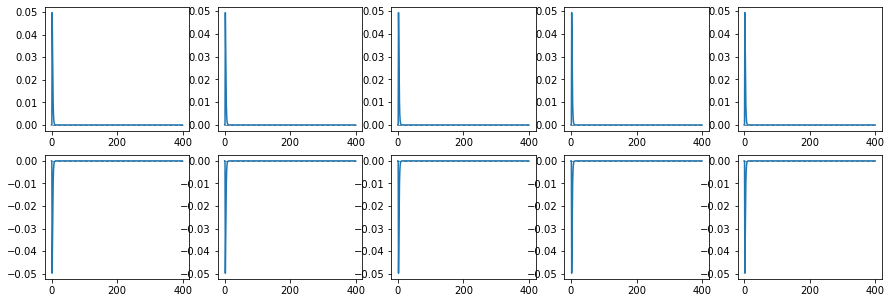

In [7]:
sub_no = 5
fig, axs = plt.subplots(nrows=2, ncols=sub_no, figsize=(15,5))
for row in range(2):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:400])
        axs[row,col].hlines(y=0,xmin=0,xmax=400, color="gray",linewidth=1,linestyle="--")

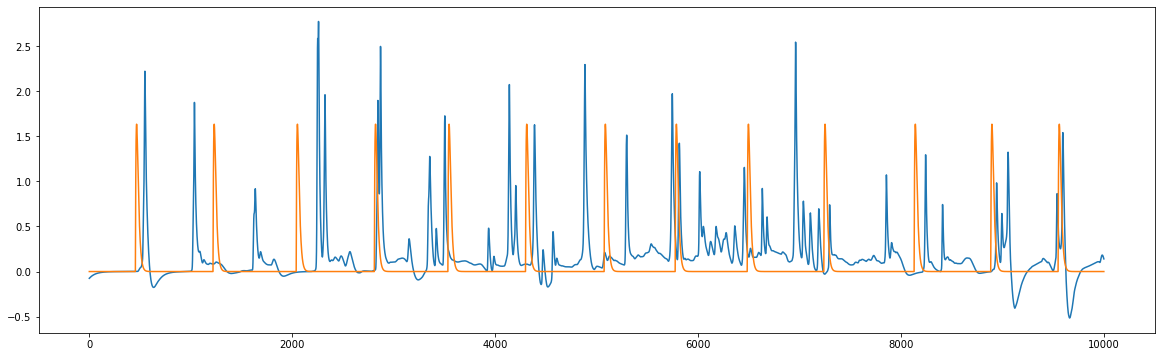

In [8]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


In [9]:
plt.figure(figsize=(20,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[16000:24000])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[16000:24000])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))


NameError: name 'filt_test_Z' is not defined

<Figure size 1440x360 with 0 Axes>

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

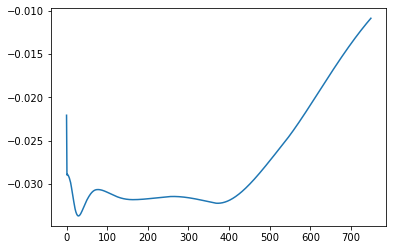

In [11]:
plt.plot(out_filters[-1].cpu().detach().numpy())

In [36]:
old = np.load("/media/hdd01/sklee/CA1_clust4-60/alpha_sub6_output.npz")["test"]
ref = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")[:,:50000].flatten()[300000:350000]

In [37]:
new = old[375:] + filt_test_pred_Z[:-375].cpu().detach().numpy()*3

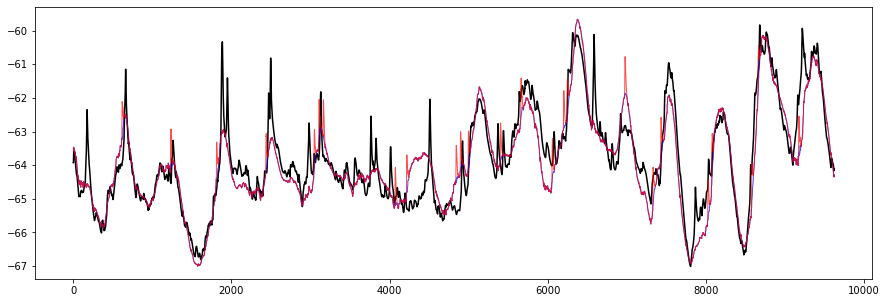

In [41]:
plt.figure(figsize = (15,5))
plt.plot(ref[16000+375:26000], c="black")
plt.plot(old[16000+375:26000], c="blue", alpha=0.7, linewidth=1)
plt.plot(new[16000:26000-375], c="red", alpha=0.7, linewidth=1)

In [27]:
diff = np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff.npy")[300000:350000]

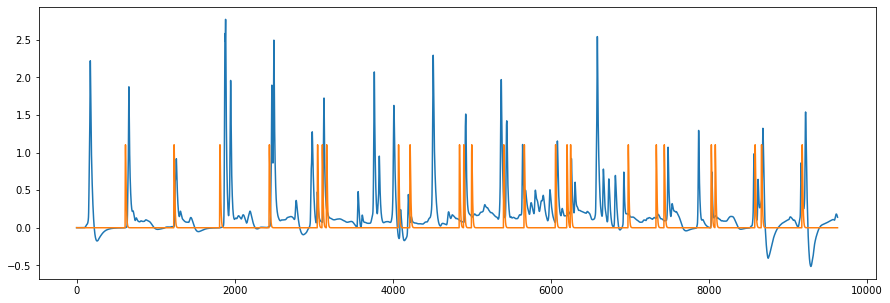

In [35]:
plt.figure(figsize  = (15,5))
plt.plot(diff[16000+375:26000])
plt.plot(filt_test_pred_Z[16000:26000-375].cpu().detach().numpy()*3)

tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)


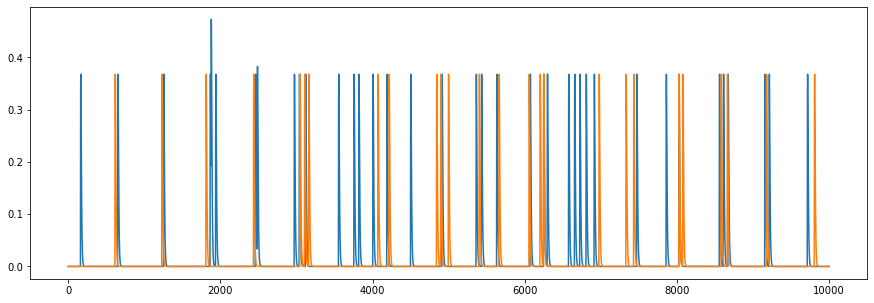

In [33]:
plt.figure(figsize=(15,5))
plt.plot(filt_test_Z.cpu().detach().numpy()[16000:26000])
plt.plot(filt_test_pred_Z.cpu().detach().numpy()[16000:26000])
print(torch.mean((filt_test_Z - filt_test_pred_Z)**2))


In [47]:
old_var = explained_variance_score(ref, old)
new_var = explained_variance_score(ref[375:], new)

In [48]:
print(old_var, new_var)

0.9141887469103781 0.9135872916297291
